# Problem 1: Network Compression Using SVD

In [218]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import librosa
import os
import soundfile as sf

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [ ]:
x_train = x_train / 255.0
x_test = x_test / 255.0
x_train = np.reshape(x_train, [-1, 784])
x_test = np.reshape(x_test, [-1, 784])

In [ ]:
initializer = tf.keras.initializers.HeNormal()
base = tf.keras.models.Sequential([
  tf.keras.layers.Dense(1024, activation='relu', kernel_initializer=initializer),
  tf.keras.layers.Dense(1024, activation='relu'),
  tf.keras.layers.Dense(1024, activation='relu'),
  tf.keras.layers.Dense(1024, activation='relu'),
  tf.keras.layers.Dense(1024, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])

In [ ]:
base.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
base_hist = base.fit(x_train, y_train, epochs=20, batch_size = 128)

Epoch 1/20
469/469 [==============================] - 4s 4ms/step - loss: 0.2205 - accuracy: 0.9334
Epoch 2/20
469/469 [==============================] - 2s 4ms/step - loss: 0.0987 - accuracy: 0.9713
Epoch 3/20
469/469 [==============================] - 2s 4ms/step - loss: 0.0687 - accuracy: 0.9804
Epoch 4/20
469/469 [==============================] - 2s 4ms/step - loss: 0.0541 - accuracy: 0.9844
Epoch 5/20
469/469 [==============================] - 2s 4ms/step - loss: 0.0506 - accuracy: 0.9860
Epoch 6/20
469/469 [==============================] - 2s 4ms/step - loss: 0.0368 - accuracy: 0.9894
Epoch 7/20
469/469 [==============================] - 2s 4ms/step - loss: 0.0360 - accuracy: 0.9903
Epoch 8/20
469/469 [==============================] - 2s 4ms/step - loss: 0.0319 - accuracy: 0.9913
Epoch 9/20
469/469 [==============================] - 2s 4ms/step - loss: 0.0250 - accuracy: 0.9933
Epoch 10/20
469/469 [==============================] - 2s 4ms/step - loss: 0.0263 - accuracy: 0.9930

In [ ]:
base.evaluate(x_test,y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.1186 - accuracy: 0.9816


[0.11857394874095917, 0.9815999865531921]

In [ ]:
S, U, V, B = [], [], [], []
for i in range(len(base.layers) - 1):
    layer = base.layers[i]
    if isinstance(layer, tf.keras.layers.Dense):
        weights, biases = layer.get_weights()
        s, u, v = tf.linalg.svd(weights)
        S.append(tf.linalg.diag(s))
        U.append(u)
        V.append(v)
        B.append(biases)

In [ ]:
def svd(S, U, V, bias, model, rank):
  for i in range(len(model.layers) - 1):
    compressed_weights = tf.matmul(tf.matmul(U[i][:, :rank], S[i][:rank,:rank]), tf.transpose(V[i][:, :rank]))
    model.layers[i].set_weights([compressed_weights, bias[i]])


  eval = model.evaluate(x_test,y_test)
  accuracy = eval[1]
  params = 784*rank + rank*rank + rank*1024 + 1024 + 4*(1024*rank + rank*rank + rank*1024 + 1024) + 1024*10+10
  return accuracy, params

In [ ]:
accuracy_list = []
params_list = []
for i in [10,20,50,100,200,784]:
  accuracy_list.append(svd(S, U, V, B, base, i)[0])
  params_list.append(svd(S, U, V, B, base, i)[1])

313/313 [==============================] - 1s 2ms/step - loss: 0.1275 - accuracy: 0.9829


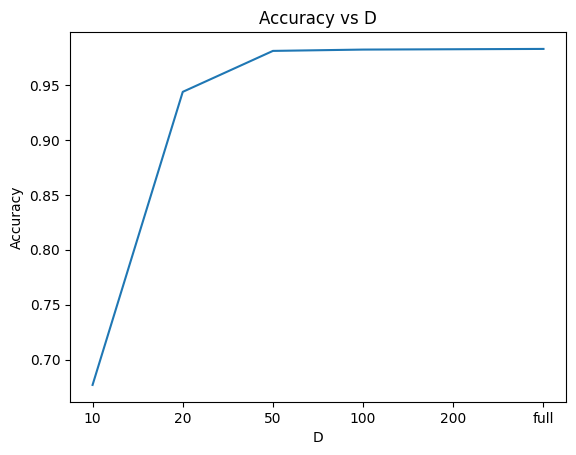

In [ ]:
D = [10,20, 50, 100, 200, 'full']
plt.plot(D, accuracy_list)
plt.xlabel("D")
plt.ylabel("Accuracy")
plt.title("Accuracy vs D")
plt.show()

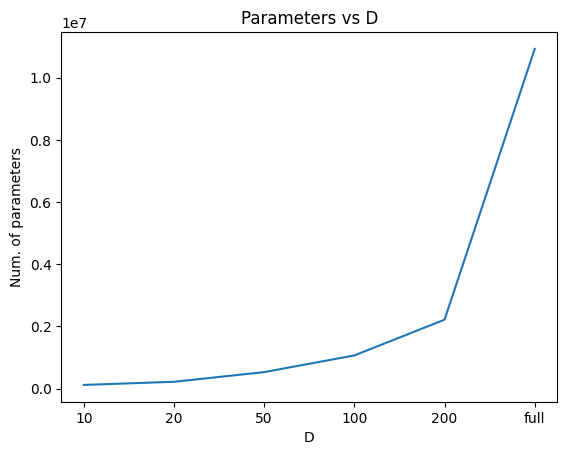

In [ ]:
D = [10,20, 50, 100, 200, 'full']
plt.plot(D, params_list)
plt.xlabel("D")
plt.ylabel("Num. of parameters")
plt.title("Parameters vs D")
plt.show()

# Problem 2: Network Compression Using SVD

In [ ]:
class FactorizedDense(tf.keras.layers.Layer):
    def __init__(self, units, rank, activation, **kwargs):
        super(FactorizedDense, self).__init__(**kwargs)
        self.units = units
        self.rank = rank
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        self.U = self.add_weight("U_matrix", shape=(input_shape[-1], self.rank),
                                initializer="glorot_normal", trainable=True)
        self.V = self.add_weight("V_matrix", shape=(self.rank, self.units),
                                initializer="glorot_normal", trainable=True)
        self.bias = self.add_weight("bias", shape=(self.units,),
                                initializer="zeros", trainable=True)
        super(FactorizedDense, self).build(input_shape)

    def call(self, inputs):
        output = tf.matmul(tf.matmul(inputs, self.U), self.V)
        output = output + self.bias
        output = self.activation(output)
        return output

In [ ]:
svd20_uv = tf.keras.Sequential()
svd20_uv.add(FactorizedDense(1024, 20, activation='relu', input_shape=(28 * 28,)))
svd20_uv.add(FactorizedDense(1024, 20, activation='relu'))
svd20_uv.add(FactorizedDense(1024, 20, activation='relu'))
svd20_uv.add(FactorizedDense(1024, 20, activation='relu'))
svd20_uv.add(FactorizedDense(1024, 20, activation='relu'))
svd20_uv.add(tf.keras.layers.Dense(10, activation='softmax'))

In [ ]:
svd20_uv.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Use a smaller learning rate
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])

In [ ]:
for i in range(len(base.layers) - 1):
    layer = base.layers[i]
    if isinstance(layer, tf.keras.layers.Dense):
        weights, biases = layer.get_weights()
        s, u, v = tf.linalg.svd(weights)
        s = tf.linalg.diag(s)
        ul, vl = u[:,:20], tf.matmul(s[:20,:20],tf.transpose(v[:,:20]))
        svd20_uv.layers[i].set_weights([ul, vl, biases])

In [ ]:
svd20_uv_hist = svd20_uv.fit(x_train, y_train, epochs=20)

Epoch 1/20
1875/1875 [==============================] - 9s 4ms/step - loss: 0.5818 - accuracy: 0.8024
Epoch 2/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1758 - accuracy: 0.9466
Epoch 3/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1306 - accuracy: 0.9598
Epoch 4/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1124 - accuracy: 0.9648
Epoch 5/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0969 - accuracy: 0.9702
Epoch 6/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0891 - accuracy: 0.9730
Epoch 7/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0813 - accuracy: 0.9744
Epoch 8/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0756 - accuracy: 0.9759
Epoch 9/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0702 - accuracy: 0.9783
Epoch 10/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.064

In [ ]:
svd20_uv.evaluate(x_test,y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.0956 - accuracy: 0.9743


[0.0956331267952919, 0.9743000268936157]

# Problem 3: Network Compression Using SVD

In [ ]:
class DenseSVD(tf.keras.layers.Layer):
    def __init__(self, units, rank, activation, **kwargs):
        super(DenseSVD, self).__init__(**kwargs)
        self.units = units
        self.rank = rank
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        self.w = self.add_weight("w", shape=(input_shape[-1], self.units),
                                initializer='glorot_normal', trainable=True)
        self.bias = self.add_weight("bias", shape=(self.units,),
                                initializer="zeros", trainable=True)
        super(DenseSVD, self).build(input_shape)

    def call(self, inputs):
        s, u, v = tf.linalg.svd(self.w)
        s = tf.linalg.diag(s)
        w_hat = tf.matmul(tf.matmul(u[:, :self.rank], s[:self.rank, :self.rank]), tf.transpose(v[:, :self.rank]))
        output = tf.matmul(inputs, w_hat) + self.bias
        output = self.activation(output)
        return output

In [ ]:
svd20_svd = tf.keras.Sequential()
svd20_svd.add(DenseSVD(1024, 20, activation='relu', input_shape=(28 * 28,)))
svd20_svd.add(DenseSVD(1024, 20, activation='relu'))
svd20_svd.add(DenseSVD(1024, 20, activation='relu'))
svd20_svd.add(DenseSVD(1024, 20, activation='relu'))
svd20_svd.add(DenseSVD(1024, 20, activation='relu'))
svd20_svd.add(tf.keras.layers.Dense(10, activation='softmax'))

In [ ]:
svd20_svd.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Use a smaller learning rate
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])

In [ ]:
for i in range(len(base.layers) - 1):
    layer = base.layers[i]
    if isinstance(layer, tf.keras.layers.Dense):
        weights, biases = layer.get_weights()
        s, u, v = tf.linalg.svd(weights)
        s = tf.linalg.diag(s)
        w = tf.matmul(tf.matmul(u[:,:20],s[:20,:20]),tf.transpose(v[:,:20]))
        svd20_svd.layers[i].set_weights([w, biases])

In [ ]:
svd20_svd.fit(x_train, y_train, epochs=10,batch_size=1024)

Epoch 1/10
59/59 [==============================] - 159s 3s/step - loss: 0.3962 - accuracy: 0.8970
Epoch 2/10
59/59 [==============================] - 156s 3s/step - loss: 0.0604 - accuracy: 0.9838
Epoch 3/10
59/59 [==============================] - 155s 3s/step - loss: 0.0414 - accuracy: 0.9881
Epoch 4/10
59/59 [==============================] - 154s 3s/step - loss: 0.0316 - accuracy: 0.9907
Epoch 5/10
59/59 [==============================] - 154s 3s/step - loss: 0.0266 - accuracy: 0.9919
Epoch 6/10
59/59 [==============================] - 154s 3s/step - loss: 0.0242 - accuracy: 0.9927
Epoch 7/10
59/59 [==============================] - 154s 3s/step - loss: 0.0208 - accuracy: 0.9933
Epoch 8/10
59/59 [==============================] - 153s 3s/step - loss: 0.0165 - accuracy: 0.9948
Epoch 9/10
59/59 [==============================] - 153s 3s/step - loss: 0.0176 - accuracy: 0.9947
Epoch 10/10
59/59 [==============================] - 153s 3s/step - loss: 0.0180 - accuracy: 0.9944


In [ ]:
svd20_svd.evaluate(x_test,y_test)

313/313 [==============================] - 804s 3s/step - loss: 0.0952 - accuracy: 0.9810


[0.09518812596797943, 0.9810000061988831]

# Problem 4: Speaker Verification

In [ ]:
import pickle

with open('trs.pkl', 'rb') as file:
    train = pickle.load(file)
with open('tes.pkl', 'rb') as file:
    test = pickle.load(file)

In [ ]:
def positive(n,data, L):
    pairs = [(a, b) for a in range(10) for b in range(a+1,10)]
    out = []
    pairs_L = random.sample(pairs, L)


    for x,y in pairs_L:
        stft1 = np.abs(librosa.stft(data[n*10+x], n_fft=1024, hop_length=512)).T
        stft2 = np.abs(librosa.stft(data[n*10+y], n_fft=1024, hop_length=512)).T
        out.append([stft1, stft2])


    return out

In [ ]:
def negative(n, data, L):
  b_data = data[n*10: (n+1)*10]
  a_data = np.append(data[:n*10],data[n*10+10:],0)

  a_index = random.sample(range(len(a_data)),L)
  b_index = []
  while L > 10:
    b_index += random.sample(range(10),10)
    L -= 10
  b_index += random.sample(range(10),L)

  out = []



  for x,y in zip(a_index, b_index):
      stft1 = np.abs(librosa.stft(a_data[x], n_fft=1024, hop_length=512)).T
      stft2 = np.abs(librosa.stft(b_data[y], n_fft=1024, hop_length=512)).T
      out.append([stft1, stft2])


  return out

In [ ]:
x_train = []
batch_size = 10
for i in range(int(len(train)/10)):
  x_train += positive(i, train, batch_size)
  x_train += negative(i, train, batch_size)
x_train = np.stack(x_train)

In [ ]:
x_test = []
batch_size = 10
for i in range(int(len(test)/10)):
  x_test += positive(i, test, batch_size)
  x_test += negative(i, test, batch_size)
x_test = np.stack(x_test)

In [ ]:
y_train = []
for i in range(int(len(train)/10)):
    y_train.append(np.append(np.ones(batch_size),np.zeros(batch_size)))
y_train = np.hstack(y_train)
y_test = []
for i in range(int(len(test)/10)):
    y_test.append(np.append(np.ones(batch_size),np.zeros(batch_size)))
y_test = np.hstack(y_test)

In [ ]:
x_test.shape

(1800, 2, 45, 513)

#### Create siamese network

In [ ]:
create_siamese = tf.keras.Sequential()
create_siamese.add(tf.keras.layers.GRU(64, return_sequences = False,activation='relu'))
create_siamese.add(tf.keras.layers.Dense(64, activation = 'relu'))

postive_input = tf.keras.layers.Input([None,513])
negative_input = tf.keras.layers.Input([None,513])
postive_out = create_siamese(postive_input)
negative_out = create_siamese(negative_input)

similarity_score = tf.multiply(postive_out, negative_out)
similarity_score = tf.keras.layers.Dense(1,activation='sigmoid')(similarity_score)

siamese = tf.keras.models.Model(inputs = [postive_input,negative_input], outputs = similarity_score)

In [ ]:
siamese.compile(optimizer=tf.keras.optimizers.Adam(0.001),loss='binary_crossentropy',metrics=[tf.keras.metrics.BinaryAccuracy()])

In [ ]:
siamese.fit([x_train[:, 0], x_train[:, 1]], y_train, batch_size=32, epochs=50)

Epoch 1/50
141/141 [==============================] - 12s 64ms/step - loss: 0.6956 - binary_accuracy: 0.5051
Epoch 2/50
141/141 [==============================] - 9s 67ms/step - loss: 0.6708 - binary_accuracy: 0.5756
Epoch 3/50
141/141 [==============================] - 10s 68ms/step - loss: 0.5628 - binary_accuracy: 0.6944
Epoch 4/50
141/141 [==============================] - 9s 65ms/step - loss: 0.4771 - binary_accuracy: 0.7707
Epoch 5/50
141/141 [==============================] - 9s 64ms/step - loss: 0.3919 - binary_accuracy: 0.8318
Epoch 6/50
141/141 [==============================] - 9s 64ms/step - loss: 0.3479 - binary_accuracy: 0.8487
Epoch 7/50
141/141 [==============================] - 9s 64ms/step - loss: 0.3202 - binary_accuracy: 0.8676
Epoch 8/50
141/141 [==============================] - 9s 66ms/step - loss: 0.2788 - binary_accuracy: 0.8831
Epoch 9/50
141/141 [==============================] - 9s 65ms/step - loss: 0.2475 - binary_accuracy: 0.8993
Epoch 10/50
141/141 [=====

##### Classification accuracy

In [ ]:
siamese.evaluate([x_test[:, 0], x_test[:, 1]] ,y_test)

57/57 [==============================] - 1s 19ms/step - loss: 1.3806 - binary_accuracy: 0.6911


[1.3805829286575317, 0.6911110877990723]

## Problem 5: Speech Denoising Using RNN

In [131]:
os.chdir('/content/drive/My Drive/tr')
name_list = os.listdir('.')
name_list.sort()

In [132]:
name_list[1200]

'trs0000.wav'

In [133]:
trn = []
for i in range(1200):
    s, sr = librosa.load(name_list[i], sr=None)
    s_ab = np.abs(librosa.stft(s, n_fft=1024, hop_length=512))
    padding = np.zeros((513,178))
    padding[:, :s_ab.shape[1]] = s_ab
    trn.append(padding.T)

In [134]:
trs = []
for i in range(1200,2400):
    s, sr = librosa.load(name_list[i], sr=None)
    s_ab = np.abs(librosa.stft(s, n_fft=1024, hop_length=512))
    padding = np.zeros((513,178))
    padding[:, :s_ab.shape[1]] = s_ab
    trs.append(padding.T)

In [135]:
trx = []
for i in range(2400,3600):
    s, sr = librosa.load(name_list[i], sr=None)
    s_ab = np.abs(librosa.stft(s, n_fft=1024, hop_length=512))
    padding = np.zeros((513,178))
    padding[:, :s_ab.shape[1]] = s_ab
    trx.append(padding.T)

In [136]:
ibm = []
for i in range(len(trx)):
  ibm_i = np.zeros((178,513))
  ibm_i[trs[i] > trn[i]] = 1
  ibm.append(ibm_i)

In [137]:
x_train = np.stack(trx)
y_train = np.stack(ibm)

In [146]:
lstm_model = tf.keras.models.Sequential()
lstm_model.add(tf.keras.layers.LSTM(units=1024, return_sequences=True))
lstm_model.add(tf.keras.layers.Dropout(rate = 0.2))
lstm_model.add(tf.keras.layers.LSTM(units=1024, return_sequences=True))
lstm_model.add(tf.keras.layers.Dropout(rate = 0.2))
lstm_model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=513, activation='sigmoid')))

In [147]:
lstm_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), loss = 'binary_crossentropy')

In [148]:
lstm_model.fit(x_train, y_train, epochs=100, batch_size=10)

Epoch 1/100
120/120 [==============================] - 21s 127ms/step - loss: 0.4494
Epoch 2/100
120/120 [==============================] - 16s 131ms/step - loss: 0.3523
Epoch 3/100
120/120 [==============================] - 16s 132ms/step - loss: 0.3151
Epoch 4/100
120/120 [==============================] - 16s 131ms/step - loss: 0.2886
Epoch 5/100
120/120 [==============================] - 16s 129ms/step - loss: 0.2742
Epoch 6/100
120/120 [==============================] - 15s 129ms/step - loss: 0.2609
Epoch 7/100
120/120 [==============================] - 16s 130ms/step - loss: 0.2579
Epoch 8/100
120/120 [==============================] - 16s 130ms/step - loss: 0.2500
Epoch 9/100
120/120 [==============================] - 16s 131ms/step - loss: 0.2431
Epoch 10/100
120/120 [==============================] - 16s 130ms/step - loss: 0.2396
Epoch 11/100
120/120 [==============================] - 16s 130ms/step - loss: 0.2359
Epoch 12/100
120/120 [==============================] - 16s 130

### Predict on validation set

In [149]:
os.chdir('/content/drive/My Drive/v')
name_list = os.listdir('.')
name_list.sort()

In [162]:
vx = []
for i in range(2400,3600):
    s, sr = librosa.load(name_list[i], sr=None)
    s_ab = np.abs(librosa.stft(s, n_fft=1024, hop_length=512))
    padding = np.zeros((513,178))
    padding[:, :s_ab.shape[1]] = s_ab
    vx.append(padding.T)
x_v = np.stack(vx)

In [163]:
predict = lstm_model.predict(x_v, batch_size=10)

120/120 [==============================] - 8s 66ms/step


In [189]:
vx_cpx = []
for i in range(2400,3600):
    s, sr = librosa.load(name_list[i], sr=None)
    s = librosa.stft(s, n_fft=1024, hop_length=512)
    padding = np.zeros((513,178))*(0+0j)
    padding[:, :s.shape[1]] = s
    vx_cpx.append(padding.T)

x_v_cpx = np.stack(vx_cpx)

In [196]:
s_v = np.multiply(predict,x_v_cpx)

In [210]:
snr = 0
for i in range(1200,2400):
    s, sr = librosa.load(name_list[i], sr=None)
    s_stft = librosa.stft(s, n_fft=1024, hop_length=512)

    denoised = s_v[i-1200][:s_stft.shape[1]]
    recon = librosa.istft(denoised.T,hop_length=512, length=s.shape[0])
    new_snr = 10 * np.log10(np.sum(np.square(s))/np.sum(np.square(s-recon)))
    snr += new_snr

print(snr / 1200)

12.445149718283155


### Make prediction on testing set

In [248]:
os.chdir('/content/drive/My Drive/te')
name_list = os.listdir('.')
name_list.sort()

In [249]:
tex = []
tex_cpx=[]
for i in range(len(name_list)):
    s, sr = librosa.load(name_list[i], sr=None)
    s = librosa.stft(s, n_fft=1024, hop_length=512)
    padding = np.zeros((513,195))*(0+0j)
    padding[:, :s.shape[1]] = s
    tex_cpx.append(padding.T)
    tex.append(np.abs(padding.T))
tex = np.stack(tex)
tex_cpx = np.stack(tex_cpx)

In [250]:
prediction_test = lstm_model.predict(tex,batch_size=10)

38/38 [==============================] - 4s 67ms/step


In [252]:
s_te = np.multiply(prediction_test,tex_cpx)

In [253]:
for i in range(len(prediction_test)):
  s, sr = librosa.load(name_list[i], sr=None)
  denoised = librosa.istft(prediction_test[i].T, hop_length=512)

  denoised = denoised[:len(s)]
  sf.write(name_list[i][:-4]+"_denoised.wav", denoised, sr)

In [255]:
os.chdir('/content')

In [237]:
!jupyter nbconvert DLS_HW3_Tianyu_Sun.ipynb --to html

[NbConvertApp] Converting notebook DLS_HW3_Tianyu_Sun.ipynb to html
[NbConvertApp] Writing 775745 bytes to DLS_HW3_Tianyu_Sun.html
